In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("data/training_v2.csv")
samplesubmission = pd.read_csv("data/samplesubmission.csv")
test = pd.read_csv("data/unlabeled.csv")
dictionary = pd.read_csv("data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,age,aids,albumin_apache,apache_2_bodysystem,apache_2_diagnosis,apache_3j_bodysystem,apache_3j_diagnosis,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,apache_post_operative,arf_apache,bilirubin_apache,bmi,bun_apache,cirrhosis,creatinine_apache,d1_albumin_max,d1_albumin_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_heartrate_max,d1_heartrate_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_resprate_max,d1_resprate_min,d1_sodium_max,d1_sodium_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus,elective_surgery,encounter_id,ethnicity,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,gender,glucose_apache,h1_albumin_max,h1_albumin_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_heartrate_max,h1_heartrate_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_resprate_max,h1_resprate_min,h1_sodium_max,h1_sodium_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,h1_wbc_max,h1_wbc_min,heart_rate_apache,height,hematocrit_apache,hepatic_failure,hospital_admit_source,hospital_death,hospital_id,icu_admit_source,icu_admit_type,icu_id,icu_stay_type,icu_type,immunosuppression,intubated_apache,leukemia,lymphoma,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,patient_id,ph_apache,pre_icu_los_days,pred,readmission_status,resprate_apache,sodium_apache,solid_tumor_with_metastasis,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,weight
Category,demographic,APACHE comorbidity,APACHE covariate,APACHE grouping,APACHE covariate,APACHE grouping,APACHE covariate,APACHE prediction,APACHE prediction,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,APACHE comorbidity,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,labs,labs,vitals,vitals,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs blood gas,labs blood gas,labs,labs,labs,labs,vitals,vitals,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,APACHE comorbidity,demographic,identifier,demographic,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas

# OverView of the dataset

In [4]:
train_stat2.T.head(200)

,Category,Unit of Measure,Data Type,Description,Example,count,mean,std,min,25%,50%,75%,max
age,demographic,Years,numeric,The age of the patient on unit admission,None,"87,485.00",62.31,16.78,16.00,52.00,65.00,75.00,89.00
aids,APACHE comorbidity,None,binary,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),1,"90,998.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
albumin_apache,APACHE covariate,g/L,numeric,The albumin concentration measured during the first 24 hours which results in the highest APACHE III score,30,"37,334.00",2.90,0.68,1.20,2.40,2.90,3.40,4.60
apache_2_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE II,Respiratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_2_diagnosis,APACHE covariate,None,string,The APACHE II diagnosis for the ICU admission,308,"90,051.00",185.40,86.05,101.00,113.00,122.00,301.00,308.00
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_3j_diagnosis,APACHE covariate,None,string,The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission,1405,"90,612.00",558.22,463.27,0.01,203.01,409.02,703.03,"2,201.05"
apache_4a_hospital_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",0.31,"83,766.00",0.09,0.25,-1.00,0.02,0.05,0.13,0.99
apache_4a_icu_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",0.24,"83,766.00",0.04,0.22,-1.00,0.01,0.02,0.06,0.97
apache_post_operative,APACHE covariate,None,binary,"The APACHE operative status; 1 for post-operative, 0 for non-operative",1,"91,713.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


## EDA

In [5]:
# Missing Values
train.isna().sum()

encounter_id                     0    
patient_id                       0    
hospital_id                      0    
hospital_death                   0    
age                              4228 
bmi                              3429 
elective_surgery                 0    
ethnicity                        1395 
gender                           25   
height                           1334 
hospital_admit_source            21409
icu_admit_source                 112  
icu_id                           0    
icu_stay_type                    0    
icu_type                         0    
pre_icu_los_days                 0    
readmission_status               0    
weight                           2720 
albumin_apache                   54379
apache_2_diagnosis               1662 
apache_3j_diagnosis              1101 
apache_post_operative            0    
arf_apache                       715  
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

## Functions

In [6]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [7]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [8]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

## Feature Engineering 

In [9]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [10]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



In [11]:
# Drop the values above a certain threshold
# If the information contained in the variable is not that high, you can drop the variable 
# if it has more than 50% missing values. In this method we are dropping columns with null values above a 
# certain threshold

threshold = len(train) * 0.60

df_train_thresh = train.dropna(axis=1, thresh=threshold)

# View columns in the dataset
display(df_train_thresh.shape)

print('Columns that were removed:')
list(set(train.columns) - set(df_train_thresh.columns))

(91713, 112)

Columns that were removed:


['h1_wbc_max',
 'h1_lactate_min',
 'albumin_apache',
 'paco2_for_ph_apache',
 'h1_bun_max',
 'h1_lactate_max',
 'h1_potassium_min',
 'h1_bilirubin_min',
 'h1_creatinine_min',
 'h1_inr_min',
 'h1_sysbp_invasive_max',
 'urineoutput_apache',
 'd1_lactate_min',
 'fio2_apache',
 'h1_bilirubin_max',
 'h1_hemaglobin_max',
 'h1_arterial_pco2_min',
 'paco2_apache',
 'd1_arterial_pco2_max',
 'd1_albumin_max',
 'h1_arterial_ph_max',
 'h1_diasbp_invasive_min',
 'h1_bun_min',
 'd1_arterial_ph_max',
 'h1_hematocrit_max',
 'h1_pao2fio2ratio_max',
 'd1_pao2fio2ratio_min',
 'h1_arterial_po2_min',
 'h1_mbp_invasive_min',
 'd1_arterial_pco2_min',
 'd1_sysbp_invasive_max',
 'h1_platelets_max',
 'd1_lactate_max',
 'h1_glucose_min',
 'd1_arterial_ph_min',
 'h1_albumin_min',
 'h1_arterial_ph_min',
 'h1_calcium_min',
 'd1_sysbp_invasive_min',
 'd1_bilirubin_min',
 'd1_albumin_min',
 'h1_sodium_max',
 'h1_calcium_max',
 'd1_bilirubin_max',
 'd1_diasbp_invasive_min',
 'h1_arterial_po2_max',
 'h1_sysbp_invasive_min',
 'h1_wbc_min',
 'h1_arterial_pco2_max',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'h1_albumin_max',
 'h1_mbp_invasive_max',
 'd1_pao2fio2ratio_max',
 'd1_diasbp_invasive_max',
 'h1_hco3_max',
 'd1_arterial_po2_max',
 'd1_inr_min',
 'h1_hemaglobin_min',
 'h1_inr_max',
 'bilirubin_apache',
 'd1_inr_max',
 'h1_hco3_min',
 'd1_arterial_po2_min',
 'h1_creatinine_max',
 'h1_pao2fio2ratio_min',
 'h1_hematocrit_min',
 'pao2_apache',
 'h1_sodium_min',
 'h1_potassium_max',
 'ph_apache',
 'h1_diasbp_invasive_max',
 'h1_platelets_min',
 'h1_glucose_max']

In [12]:
para aqui

SyntaxError: invalid syntax (<ipython-input-12-b731f3ce2097>, line 1)

# Model

In [13]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [14]:
# You want Bayesian Optimization?

#BayesianOptimization = False
boll_BayesianOptimization = True

In [15]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | scale_... | subsam... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915274	valid_1's auc: 0.893986
[200]	training's auc: 0.929283	valid_1's auc: 0.900876
[300]	training's auc: 0.939405	valid_1's auc: 0.903493
[400]	training's auc: 0.947928	valid_1's auc: 0.905343
[500]	training's auc: 0.955284	valid_1's auc: 0.906272
[600]	training's auc: 0.961045	valid_1's auc: 0.9071
[700]	training's auc: 0.966555	valid_1's auc: 0.907448
[800]	training's auc: 0.970951	valid_1's auc: 0.907984
[900]	training's auc: 0.97482	valid_1's auc: 0.908013
[1000]	training's auc: 0.978276	valid_1's auc: 0.908194
[1100]	training's auc: 0.981141	valid_1's auc: 0.908316
[1200]	training's auc: 0.983872	valid_1's auc: 0.908525
[1300]	training's auc: 0.986157	valid_1's auc: 0.908557
[1

Early stopping, best iteration is:
[1428]	training's auc: 0.982164	valid_1's auc: 0.905463
Partial score of fold 3 is: 0.9054631152637383
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.912086	valid_1's auc: 0.886762
[200]	training's auc: 0.92565	valid_1's auc: 0.894696
[300]	training's auc: 0.934967	valid_1's auc: 0.899004
[400]	training's auc: 0.94251	valid_1's auc: 0.90135
[500]	training's auc: 0.948807	valid_1's auc: 0.90266
[600]	training's auc: 0.954241	valid_1's auc: 0.903817
[700]	training's auc: 0.959295	valid_1's auc: 0.904547
[800]	training's auc: 0.963744	valid_1's auc: 0.90518
[900]	training's auc: 0.967682	valid_1's auc: 0.905564
[1000]	training's auc: 0.971125	valid_1's auc: 0.90587
[1100]	training's auc: 0.973968	valid_1's auc: 0.905791
Early stopping, best iteration is:
[1062]	training's auc: 0.972923	valid_1's auc: 0.905911
Partial score of fold 4 is: 0.905910730233596
Our oof AUC score is:  0.9048431298940657
auc:  0.904843129894

[900]	training's auc: 0.974476	valid_1's auc: 0.904966
[1000]	training's auc: 0.977549	valid_1's auc: 0.905409
[1100]	training's auc: 0.980319	valid_1's auc: 0.905366
Early stopping, best iteration is:
[1055]	training's auc: 0.979096	valid_1's auc: 0.905442
Partial score of fold 0 is: 0.9054416179062441
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.918137	valid_1's auc: 0.887176
[200]	training's auc: 0.932905	valid_1's auc: 0.895089
[300]	training's auc: 0.942665	valid_1's auc: 0.898791
[400]	training's auc: 0.950443	valid_1's auc: 0.900606
[500]	training's auc: 0.957001	valid_1's auc: 0.902042
[600]	training's auc: 0.962605	valid_1's auc: 0.902831
[700]	training's auc: 0.967491	valid_1's auc: 0.903549
[800]	training's auc: 0.971557	valid_1's auc: 0.903765
[900]	training's auc: 0.975032	valid_1's auc: 0.90411
[1000]	training's auc: 0.977971	valid_1's auc: 0.904329
[1100]	training's auc: 0.980606	valid_1's auc: 0.904399
[1200]	training's auc: 0.98

[200]	training's auc: 0.921505	valid_1's auc: 0.889747
[300]	training's auc: 0.930454	valid_1's auc: 0.895487
[400]	training's auc: 0.93716	valid_1's auc: 0.898777
[500]	training's auc: 0.942914	valid_1's auc: 0.900707
[600]	training's auc: 0.947891	valid_1's auc: 0.901918
[700]	training's auc: 0.95229	valid_1's auc: 0.902799
[800]	training's auc: 0.956366	valid_1's auc: 0.90345
[900]	training's auc: 0.960172	valid_1's auc: 0.903827
[1000]	training's auc: 0.96357	valid_1's auc: 0.904013
[1100]	training's auc: 0.966614	valid_1's auc: 0.90431
[1200]	training's auc: 0.969375	valid_1's auc: 0.904371
Early stopping, best iteration is:
[1141]	training's auc: 0.967747	valid_1's auc: 0.904474
Partial score of fold 4 is: 0.9044739144507716
Our oof AUC score is:  0.9034731084890738
auc:  0.9034731084890738
|  5        |  0.9035   |  0.9548   |  2.5      |  0.194    |  0.009008 |  13.47    |  3.556    |  5.414    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.910098	valid_1's auc: 0.887635
[200]	training's auc: 0.920796	valid_1's auc: 0.8922
[300]	training's auc: 0.929192	valid_1's auc: 0.895724
[400]	training's auc: 0.936058	valid_1's auc: 0.89827
[500]	training's auc: 0.941504	valid_1's auc: 0.899977
[600]	training's auc: 0.946364	valid_1's auc: 0.901158
[700]	training's auc: 0.950699	valid_1's auc: 0.901977
[800]	training's auc: 0.954844	valid_1's auc: 0.902629
[900]	training's auc: 0.958464	valid_1's auc: 0.90327
[1000]	training's auc: 0.961765	valid_1's auc: 0.903673
[1100]	training's auc: 0.964753	valid_1's auc: 0.904016
[1200]	training's auc: 0.967496	valid_1's auc: 0.904327
[1300]	training's auc: 0.97003	valid_1's auc: 0.904532
[1400]	training's auc: 0.972348	valid_1's auc: 0.904539
[1500]	training's auc: 0.974561	valid_1's auc: 0.904543
[1600]	training's auc: 0.976466	valid_1's auc: 0.90464
[1700]	training's auc: 0.97814	valid_1's auc: 0.904643
[1

[1800]	training's auc: 0.974597	valid_1's auc: 0.902849
[1900]	training's auc: 0.976197	valid_1's auc: 0.902929
[2000]	training's auc: 0.977641	valid_1's auc: 0.902963
[2100]	training's auc: 0.979025	valid_1's auc: 0.902974
[2200]	training's auc: 0.980313	valid_1's auc: 0.902983
[2300]	training's auc: 0.98153	valid_1's auc: 0.903063
[2400]	training's auc: 0.982638	valid_1's auc: 0.903119
[2500]	training's auc: 0.983743	valid_1's auc: 0.90309
Early stopping, best iteration is:
[2409]	training's auc: 0.982741	valid_1's auc: 0.903135
Partial score of fold 3 is: 0.9031352912571242
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.908444	valid_1's auc: 0.879161
[200]	training's auc: 0.917905	valid_1's auc: 0.88444
[300]	training's auc: 0.925835	valid_1's auc: 0.889758
[400]	training's auc: 0.932392	valid_1's auc: 0.893917
[500]	training's auc: 0.937718	valid_1's auc: 0.896972
[600]	training's auc: 0.942245	valid_1's auc: 0.898724
[700]	training's auc: 0.9

Partial score of fold 2 is: 0.9001820129448179
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915143	valid_1's auc: 0.888818
[200]	training's auc: 0.929427	valid_1's auc: 0.894959
[300]	training's auc: 0.939063	valid_1's auc: 0.89815
[400]	training's auc: 0.94684	valid_1's auc: 0.899949
[500]	training's auc: 0.953376	valid_1's auc: 0.901026
[600]	training's auc: 0.958938	valid_1's auc: 0.901581
[700]	training's auc: 0.96366	valid_1's auc: 0.901852
[800]	training's auc: 0.967896	valid_1's auc: 0.902139
[900]	training's auc: 0.971539	valid_1's auc: 0.902423
[1000]	training's auc: 0.974644	valid_1's auc: 0.902523
[1100]	training's auc: 0.977514	valid_1's auc: 0.902534
Early stopping, best iteration is:
[1036]	training's auc: 0.975711	valid_1's auc: 0.902613
Partial score of fold 3 is: 0.9026128539112519
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.915419	valid_1's auc: 0.88497
[200]	training's auc: 0.92944	val

[800]	training's auc: 0.976621	valid_1's auc: 0.905167
[900]	training's auc: 0.980068	valid_1's auc: 0.905416
[1000]	training's auc: 0.983025	valid_1's auc: 0.905361
Early stopping, best iteration is:
[938]	training's auc: 0.981205	valid_1's auc: 0.905514
Partial score of fold 0 is: 0.9055137974028951
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.921426	valid_1's auc: 0.89052
[200]	training's auc: 0.936745	valid_1's auc: 0.897593
[300]	training's auc: 0.947246	valid_1's auc: 0.900844
[400]	training's auc: 0.95567	valid_1's auc: 0.902085
[500]	training's auc: 0.962635	valid_1's auc: 0.903123
[600]	training's auc: 0.968523	valid_1's auc: 0.903561
[700]	training's auc: 0.972993	valid_1's auc: 0.903959
[800]	training's auc: 0.977025	valid_1's auc: 0.90421
[900]	training's auc: 0.98054	valid_1's auc: 0.904652
[1000]	training's auc: 0.983469	valid_1's auc: 0.904691
Early stopping, best iteration is:
[936]	training's auc: 0.981646	valid_1's auc: 0.90479

[800]	training's auc: 0.956561	valid_1's auc: 0.902894
[900]	training's auc: 0.960119	valid_1's auc: 0.903514
[1000]	training's auc: 0.963303	valid_1's auc: 0.903895
[1100]	training's auc: 0.966225	valid_1's auc: 0.904164
[1200]	training's auc: 0.96896	valid_1's auc: 0.904409
[1300]	training's auc: 0.971421	valid_1's auc: 0.904593
[1400]	training's auc: 0.973693	valid_1's auc: 0.904852
[1500]	training's auc: 0.975701	valid_1's auc: 0.905019
[1600]	training's auc: 0.977616	valid_1's auc: 0.905085
[1700]	training's auc: 0.979447	valid_1's auc: 0.905239
[1800]	training's auc: 0.981078	valid_1's auc: 0.905291
[1900]	training's auc: 0.982602	valid_1's auc: 0.90542
[2000]	training's auc: 0.983953	valid_1's auc: 0.905528
[2100]	training's auc: 0.985194	valid_1's auc: 0.905558
[2200]	training's auc: 0.986386	valid_1's auc: 0.905769
[2300]	training's auc: 0.987546	valid_1's auc: 0.905789
Early stopping, best iteration is:
[2235]	training's auc: 0.986813	valid_1's auc: 0.905819
Partial score of 

[300]	training's auc: 0.940099	valid_1's auc: 0.897601
[400]	training's auc: 0.948103	valid_1's auc: 0.899407
[500]	training's auc: 0.954836	valid_1's auc: 0.900789
[600]	training's auc: 0.960271	valid_1's auc: 0.901383
[700]	training's auc: 0.965337	valid_1's auc: 0.901871
[800]	training's auc: 0.969465	valid_1's auc: 0.902152
[900]	training's auc: 0.973168	valid_1's auc: 0.902263
[1000]	training's auc: 0.97655	valid_1's auc: 0.902403
[1100]	training's auc: 0.979447	valid_1's auc: 0.902387
[1200]	training's auc: 0.98191	valid_1's auc: 0.902567
[1300]	training's auc: 0.984063	valid_1's auc: 0.902657
Early stopping, best iteration is:
[1284]	training's auc: 0.983783	valid_1's auc: 0.902774
Partial score of fold 2 is: 0.9027743687780521
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.916937	valid_1's auc: 0.890953
[200]	training's auc: 0.930025	valid_1's auc: 0.896817
[300]	training's auc: 0.939882	valid_1's auc: 0.900068
[400]	training's auc: 0.9479

[3000]	training's auc: 0.97598	valid_1's auc: 0.903874
[3100]	training's auc: 0.97701	valid_1's auc: 0.903887
[3200]	training's auc: 0.97796	valid_1's auc: 0.903844
Early stopping, best iteration is:
[3128]	training's auc: 0.977274	valid_1's auc: 0.903924
Partial score of fold 2 is: 0.9039237754362054
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.903131	valid_1's auc: 0.887772
[200]	training's auc: 0.910335	valid_1's auc: 0.890966
[300]	training's auc: 0.916529	valid_1's auc: 0.893679
[400]	training's auc: 0.921631	valid_1's auc: 0.895923
[500]	training's auc: 0.926046	valid_1's auc: 0.897787
[600]	training's auc: 0.929852	valid_1's auc: 0.899379
[700]	training's auc: 0.933211	valid_1's auc: 0.900555
[800]	training's auc: 0.936284	valid_1's auc: 0.901541
[900]	training's auc: 0.939156	valid_1's auc: 0.902288
[1000]	training's auc: 0.941867	valid_1's auc: 0.902924
[1100]	training's auc: 0.944457	valid_1's auc: 0.903429
[1200]	training's auc: 0.946

[1300]	training's auc: 0.960318	valid_1's auc: 0.903812
Early stopping, best iteration is:
[1286]	training's auc: 0.959773	valid_1's auc: 0.903914
Partial score of fold 3 is: 0.9039138586004852
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.896979	valid_1's auc: 0.880426
[200]	training's auc: 0.908688	valid_1's auc: 0.886758
[300]	training's auc: 0.918047	valid_1's auc: 0.89239
[400]	training's auc: 0.92521	valid_1's auc: 0.896657
[500]	training's auc: 0.931164	valid_1's auc: 0.899191
[600]	training's auc: 0.935886	valid_1's auc: 0.900716
[700]	training's auc: 0.940315	valid_1's auc: 0.901777
[800]	training's auc: 0.944266	valid_1's auc: 0.902734
[900]	training's auc: 0.947828	valid_1's auc: 0.903461
[1000]	training's auc: 0.951156	valid_1's auc: 0.904287
[1100]	training's auc: 0.954079	valid_1's auc: 0.904804
[1200]	training's auc: 0.956836	valid_1's auc: 0.905222
[1300]	training's auc: 0.959497	valid_1's auc: 0.905307
[1400]	training's auc: 0.96

[800]	training's auc: 0.966157	valid_1's auc: 0.902556
[900]	training's auc: 0.970068	valid_1's auc: 0.902583
Early stopping, best iteration is:
[847]	training's auc: 0.968149	valid_1's auc: 0.902697
Partial score of fold 2 is: 0.9026967616847862
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.909603	valid_1's auc: 0.89195
[200]	training's auc: 0.925492	valid_1's auc: 0.899253
[300]	training's auc: 0.935637	valid_1's auc: 0.902132
[400]	training's auc: 0.94378	valid_1's auc: 0.903482
[500]	training's auc: 0.950575	valid_1's auc: 0.90453
[600]	training's auc: 0.956457	valid_1's auc: 0.904962
[700]	training's auc: 0.961594	valid_1's auc: 0.905406
[800]	training's auc: 0.965866	valid_1's auc: 0.905704
[900]	training's auc: 0.969834	valid_1's auc: 0.905761
Early stopping, best iteration is:
[882]	training's auc: 0.969251	valid_1's auc: 0.905855
Partial score of fold 3 is: 0.9058549055792501
Training until validation scores don't improve for 100 rounds


[1500]	training's auc: 0.953094	valid_1's auc: 0.905505
[1600]	training's auc: 0.9552	valid_1's auc: 0.905861
[1700]	training's auc: 0.957134	valid_1's auc: 0.906117
[1800]	training's auc: 0.958926	valid_1's auc: 0.906485
[1900]	training's auc: 0.960789	valid_1's auc: 0.906664
[2000]	training's auc: 0.962478	valid_1's auc: 0.906786
Early stopping, best iteration is:
[1999]	training's auc: 0.962454	valid_1's auc: 0.906791
Partial score of fold 4 is: 0.9067909580042169
Our oof AUC score is:  0.905476806368749
auc:  0.905476806368749
|  20       |  0.9055   |  0.7766   |  4.916    |  4.475    |  0.006872 |  13.37    |  1.086    |  9.987    |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.912099	valid_1's auc: 0.892789
[200]	training's auc: 0.926397	valid_1's auc: 0.900562
[300]	training's auc: 0.936644	valid_1's auc: 0.903803
[400]	training's auc: 0.944913	valid_1's auc: 0.905962
[500]	training's auc: 0.952413	valid_1's auc: 0.906848
[600]	training's

Partial score of fold 2 is: 0.9040151776708676
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.904429	valid_1's auc: 0.890728
[200]	training's auc: 0.916232	valid_1's auc: 0.896827
[300]	training's auc: 0.925716	valid_1's auc: 0.900811
[400]	training's auc: 0.933033	valid_1's auc: 0.902985
[500]	training's auc: 0.939296	valid_1's auc: 0.904415
[600]	training's auc: 0.944709	valid_1's auc: 0.905374
[700]	training's auc: 0.949512	valid_1's auc: 0.905942
[800]	training's auc: 0.954043	valid_1's auc: 0.906318
[900]	training's auc: 0.95817	valid_1's auc: 0.906754
[1000]	training's auc: 0.961871	valid_1's auc: 0.907175
[1100]	training's auc: 0.965228	valid_1's auc: 0.907352
[1200]	training's auc: 0.96839	valid_1's auc: 0.907445
[1300]	training's auc: 0.971171	valid_1's auc: 0.907378
Early stopping, best iteration is:
[1204]	training's auc: 0.968503	valid_1's auc: 0.907462
Partial score of fold 3 is: 0.9074619469792435
Training until validation scores don

[1000]	training's auc: 0.97182	valid_1's auc: 0.903106
[1100]	training's auc: 0.974909	valid_1's auc: 0.903034
Early stopping, best iteration is:
[1038]	training's auc: 0.973097	valid_1's auc: 0.903158
Partial score of fold 2 is: 0.9031582581636328
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.908593	valid_1's auc: 0.891392
[200]	training's auc: 0.923235	valid_1's auc: 0.897699
[300]	training's auc: 0.933558	valid_1's auc: 0.901198
[400]	training's auc: 0.941503	valid_1's auc: 0.903257
[500]	training's auc: 0.94825	valid_1's auc: 0.904338
[600]	training's auc: 0.954289	valid_1's auc: 0.905123
[700]	training's auc: 0.95946	valid_1's auc: 0.905789
[800]	training's auc: 0.963995	valid_1's auc: 0.906273
[900]	training's auc: 0.968043	valid_1's auc: 0.906506
[1000]	training's auc: 0.971706	valid_1's auc: 0.906601
[1100]	training's auc: 0.975033	valid_1's auc: 0.906681
[1200]	training's auc: 0.977857	valid_1's auc: 0.906719
Early stopping, best iterati

[400]	training's auc: 0.920768	valid_1's auc: 0.89633
[500]	training's auc: 0.925772	valid_1's auc: 0.898884
[600]	training's auc: 0.929906	valid_1's auc: 0.900712
[700]	training's auc: 0.933483	valid_1's auc: 0.902192
[800]	training's auc: 0.936827	valid_1's auc: 0.903358
[900]	training's auc: 0.939992	valid_1's auc: 0.904171
[1000]	training's auc: 0.943004	valid_1's auc: 0.904919
[1100]	training's auc: 0.945924	valid_1's auc: 0.905377
[1200]	training's auc: 0.948709	valid_1's auc: 0.905763
[1300]	training's auc: 0.951171	valid_1's auc: 0.906128
[1400]	training's auc: 0.953558	valid_1's auc: 0.906477
[1500]	training's auc: 0.955828	valid_1's auc: 0.906676
[1600]	training's auc: 0.958041	valid_1's auc: 0.906969
[1700]	training's auc: 0.960017	valid_1's auc: 0.907271
[1800]	training's auc: 0.96194	valid_1's auc: 0.907441
[1900]	training's auc: 0.963908	valid_1's auc: 0.907513
[2000]	training's auc: 0.965671	valid_1's auc: 0.907666
Early stopping, best iteration is:
[1971]	training's auc

[1000]	training's auc: 0.971068	valid_1's auc: 0.902184
[1100]	training's auc: 0.974107	valid_1's auc: 0.902273
Early stopping, best iteration is:
[1066]	training's auc: 0.973167	valid_1's auc: 0.902401
Partial score of fold 2 is: 0.9024011084358421
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.9086	valid_1's auc: 0.892048
[200]	training's auc: 0.92402	valid_1's auc: 0.899113
[300]	training's auc: 0.93418	valid_1's auc: 0.902181
[400]	training's auc: 0.942092	valid_1's auc: 0.903715
[500]	training's auc: 0.948572	valid_1's auc: 0.904828
[600]	training's auc: 0.954469	valid_1's auc: 0.905589
[700]	training's auc: 0.959424	valid_1's auc: 0.905918
Early stopping, best iteration is:
[662]	training's auc: 0.957597	valid_1's auc: 0.905943
Partial score of fold 3 is: 0.9059434862259169
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.907893	valid_1's auc: 0.888399
[200]	training's auc: 0.923208	valid_1's auc: 0.89717

[2100]	training's auc: 0.962303	valid_1's auc: 0.90618
[2200]	training's auc: 0.963817	valid_1's auc: 0.906343
[2300]	training's auc: 0.965281	valid_1's auc: 0.906363
[2400]	training's auc: 0.966692	valid_1's auc: 0.906363
Early stopping, best iteration is:
[2309]	training's auc: 0.965425	valid_1's auc: 0.906369
Partial score of fold 3 is: 0.9063692764321917
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.897156	valid_1's auc: 0.882372
[200]	training's auc: 0.905074	valid_1's auc: 0.88722
[300]	training's auc: 0.911819	valid_1's auc: 0.890766
[400]	training's auc: 0.917345	valid_1's auc: 0.893849
[500]	training's auc: 0.922269	valid_1's auc: 0.897014
[600]	training's auc: 0.926352	valid_1's auc: 0.899156
[700]	training's auc: 0.929984	valid_1's auc: 0.90082
[800]	training's auc: 0.933169	valid_1's auc: 0.901963
[900]	training's auc: 0.936113	valid_1's auc: 0.902986
[1000]	training's auc: 0.938864	valid_1's auc: 0.903724
[1100]	training's auc: 0.941

[2300]	training's auc: 0.959297	valid_1's auc: 0.90638
[2400]	training's auc: 0.960722	valid_1's auc: 0.906489
[2500]	training's auc: 0.962131	valid_1's auc: 0.906613
[2600]	training's auc: 0.963413	valid_1's auc: 0.906738
[2700]	training's auc: 0.964615	valid_1's auc: 0.906813
[2800]	training's auc: 0.965828	valid_1's auc: 0.906894
[2900]	training's auc: 0.967012	valid_1's auc: 0.906868
Early stopping, best iteration is:
[2807]	training's auc: 0.965896	valid_1's auc: 0.906907
Partial score of fold 0 is: 0.906906541309287
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.892244	valid_1's auc: 0.876941
[200]	training's auc: 0.900099	valid_1's auc: 0.881554
[300]	training's auc: 0.906631	valid_1's auc: 0.88549
[400]	training's auc: 0.912334	valid_1's auc: 0.888333
[500]	training's auc: 0.917399	valid_1's auc: 0.891393
[600]	training's auc: 0.92192	valid_1's auc: 0.893988
[700]	training's auc: 0.925816	valid_1's auc: 0.896011
[800]	training's auc: 0.929

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.896492	valid_1's auc: 0.884146
[200]	training's auc: 0.904054	valid_1's auc: 0.888784
[300]	training's auc: 0.910441	valid_1's auc: 0.892172
[400]	training's auc: 0.915758	valid_1's auc: 0.894442
[500]	training's auc: 0.920457	valid_1's auc: 0.896964
[600]	training's auc: 0.924615	valid_1's auc: 0.899095
[700]	training's auc: 0.92818	valid_1's auc: 0.900724
[800]	training's auc: 0.931409	valid_1's auc: 0.902055
[900]	training's auc: 0.934297	valid_1's auc: 0.90307
[1000]	training's auc: 0.937034	valid_1's auc: 0.903822
[1100]	training's auc: 0.939597	valid_1's auc: 0.904487
[1200]	training's auc: 0.942106	valid_1's auc: 0.905147
[1300]	training's auc: 0.944577	valid_1's auc: 0.905597
[1400]	training's auc: 0.946859	valid_1's auc: 0.906071
[1500]	training's auc: 0.949069	valid_1's auc: 0.90651
[1600]	training's auc: 0.951169	valid_1's auc: 0.906823
[1700]	training's auc: 0.953211	valid_1's auc: 0.90715

[2800]	training's auc: 0.971143	valid_1's auc: 0.906868
Early stopping, best iteration is:
[2716]	training's auc: 0.970094	valid_1's auc: 0.906901
Partial score of fold 3 is: 0.9069010618633291
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.897086	valid_1's auc: 0.882566
[200]	training's auc: 0.90425	valid_1's auc: 0.887325
[300]	training's auc: 0.910582	valid_1's auc: 0.890534
[400]	training's auc: 0.915954	valid_1's auc: 0.893188
[500]	training's auc: 0.920592	valid_1's auc: 0.895888
[600]	training's auc: 0.924674	valid_1's auc: 0.898293
[700]	training's auc: 0.928255	valid_1's auc: 0.900178
[800]	training's auc: 0.931486	valid_1's auc: 0.901641
[900]	training's auc: 0.934465	valid_1's auc: 0.902655
[1000]	training's auc: 0.937264	valid_1's auc: 0.903437
[1100]	training's auc: 0.93989	valid_1's auc: 0.904128
[1200]	training's auc: 0.942458	valid_1's auc: 0.904756
[1300]	training's auc: 0.944845	valid_1's auc: 0.905275
[1400]	training's auc: 0.94

In [17]:
params = {'feature_fraction': 0.9,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'learning_rate': 0.1,
 'max_depth': 13,
 'subsample_freq': 1,
 'scale_pos_weight':1}

In [18]:
LGB_BO.max['params']

{'feature_fraction': 0.524207414205945,
 'lambda_l1': 4.171808735757517,
 'lambda_l2': 4.6435328298317256,
 'learning_rate': 0.007897539397989824,
 'max_depth': 16.62053004755999,
 'scale_pos_weight': 1.2199266532301127,
 'subsample_freq': 1.0276518730971627}

In [19]:
if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO.max['params'])
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.898677	valid_1's auc: 0.886274
[200]	training's auc: 0.907174	valid_1's auc: 0.890977
[300]	training's auc: 0.914479	valid_1's auc: 0.894686
[400]	training's auc: 0.920499	valid_1's auc: 0.898201
[500]	training's auc: 0.925519	valid_1's auc: 0.900704
[600]	training's auc: 0.929659	valid_1's auc: 0.902461
[700]	training's auc: 0.933339	valid_1's auc: 0.903832
[800]	training's auc: 0.936776	valid_1's auc: 0.90499
[900]	training's auc: 0.939956	valid_1's auc: 0.905722
[1000]	training's auc: 0.942845	valid_1's auc: 0.906288
[1100]	training's auc: 0.945601	valid_1's auc: 0.906736
[1200]	training's auc: 0.948397	valid_1's auc: 0.907179
[1300]	training's auc: 0.95104	valid_1's auc: 0.907603
[1400]	training's auc: 0.953469	valid_1's auc: 0.907968
[1500]	training's auc: 0.955749	valid_1's auc: 0.908317
[1600]	training's auc: 0.95782	valid_1's auc: 0.908587
[1700]	training's auc: 0.959813	valid_1's auc: 0.90874

Feature Importance from the lightgbm model (gain)

In [20]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [21]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances-lgb-v2.png')
    plt.show()

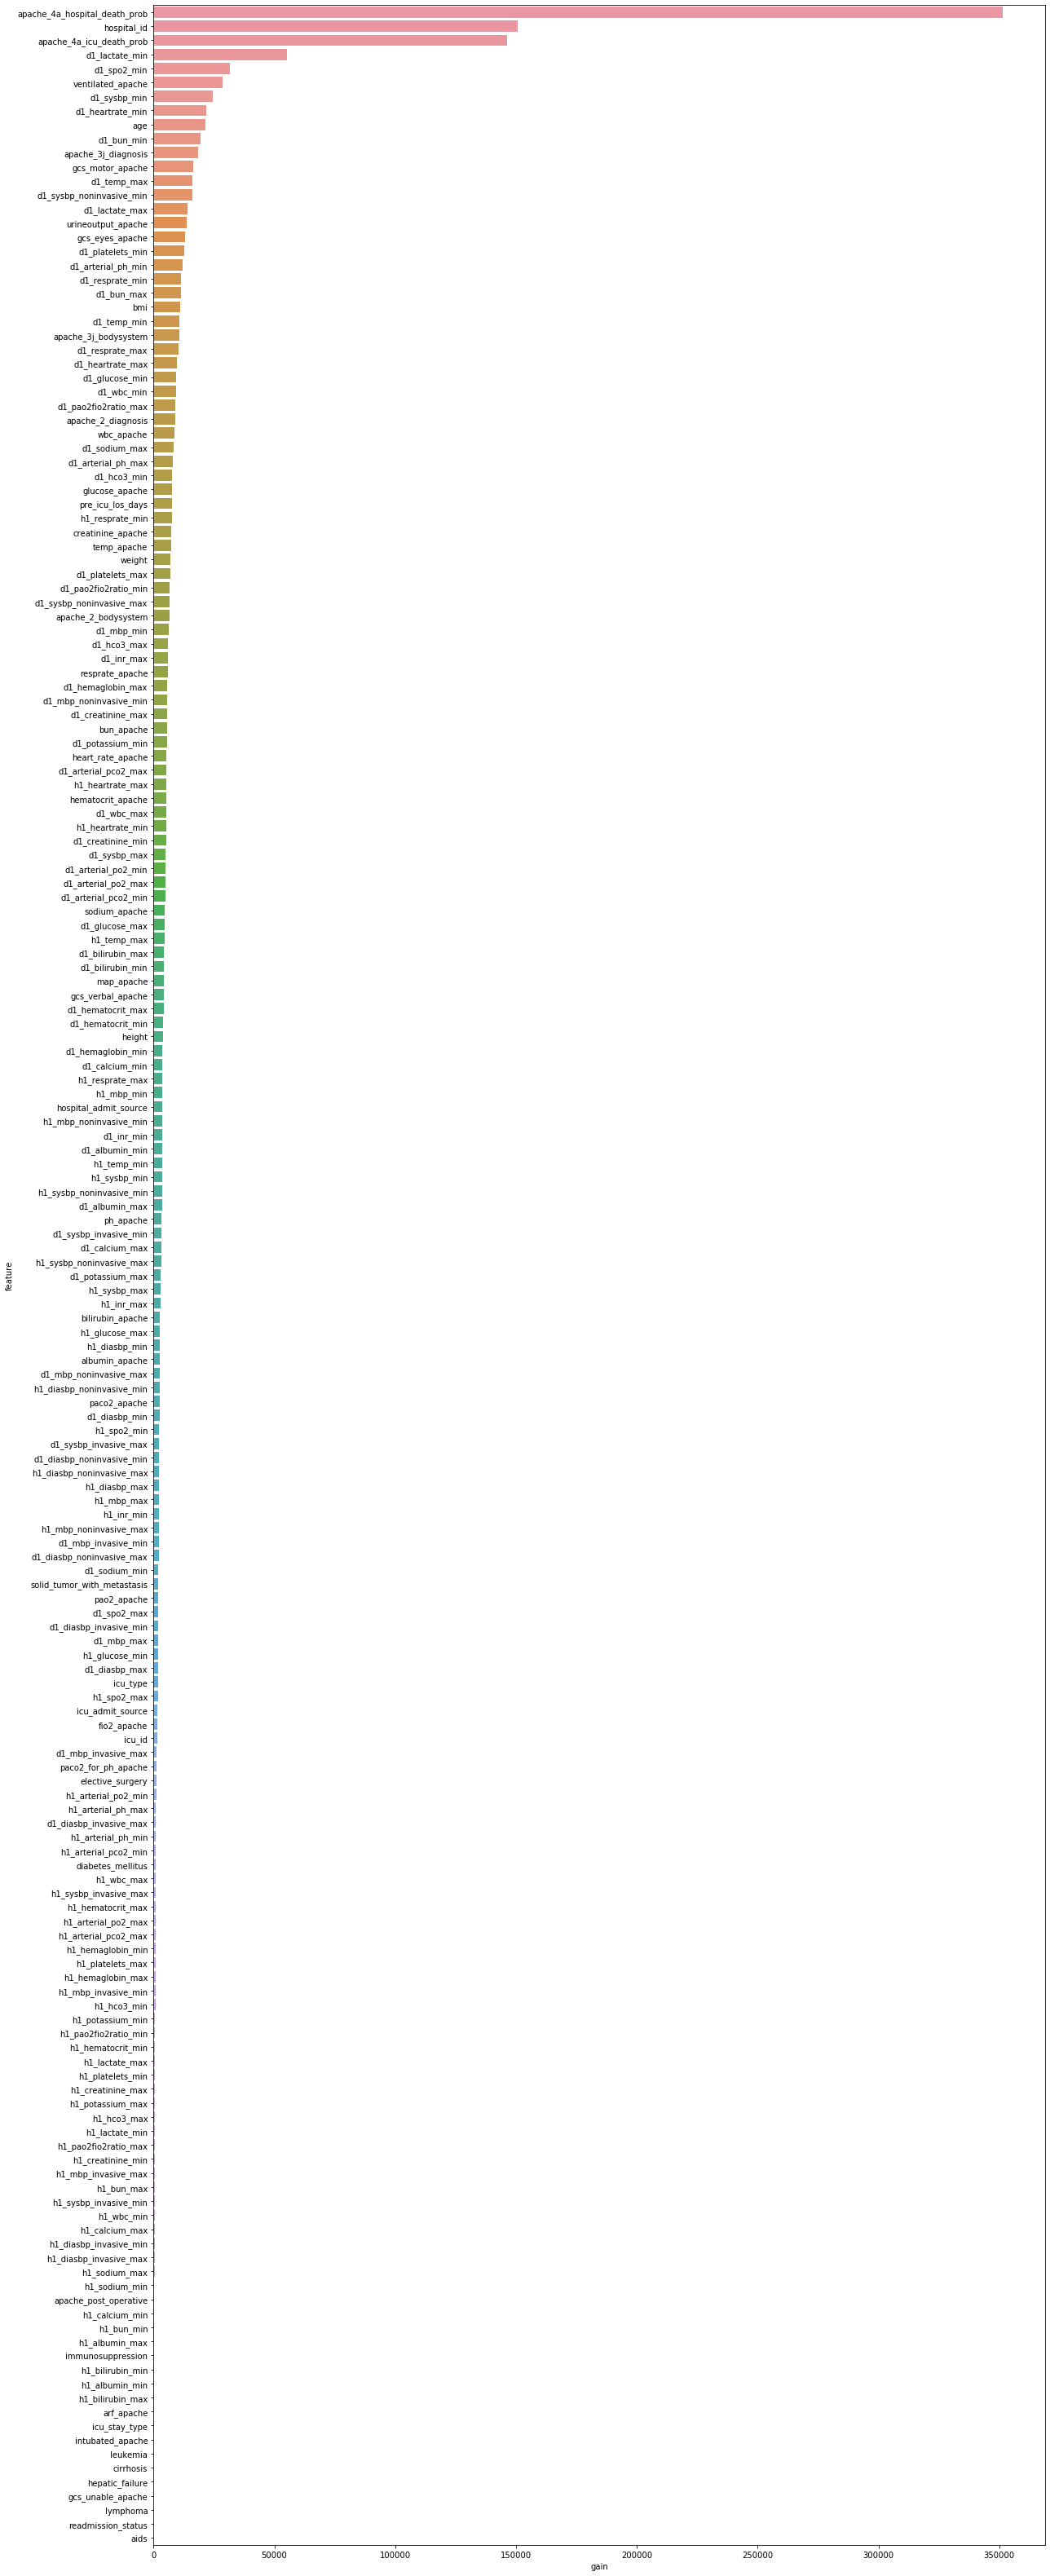

In [22]:
plot_importances(imp_df)

# Feature Importance by permutation importance algo

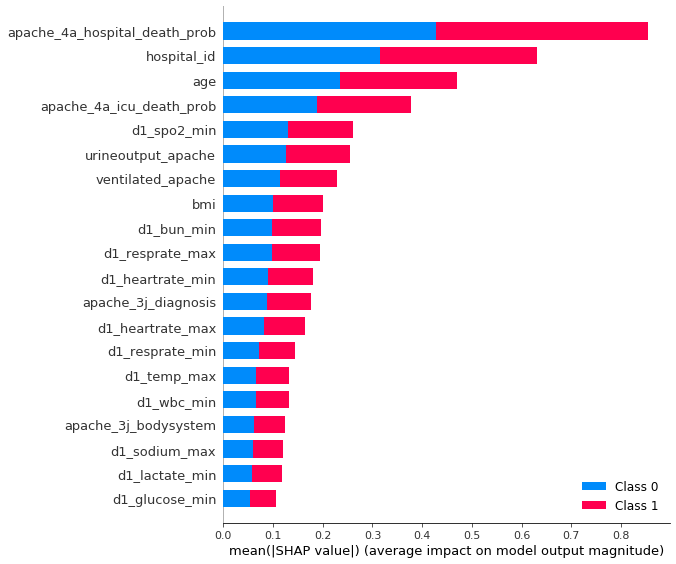

In [23]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

apache_4a_hospital_death_prob 0 gain : 351252.365885973


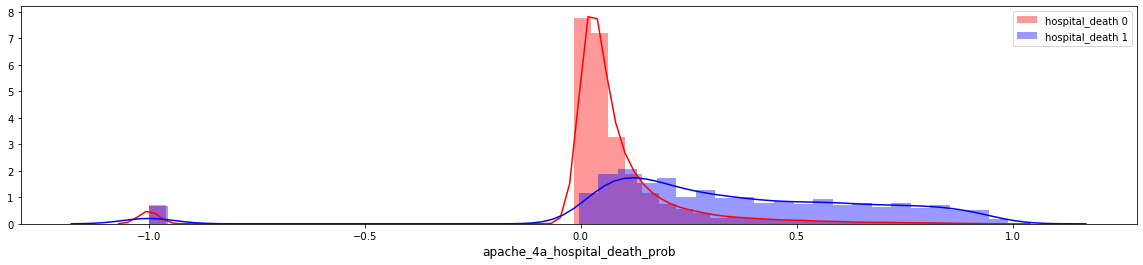

hospital_id 1 gain : 150560.84422779083


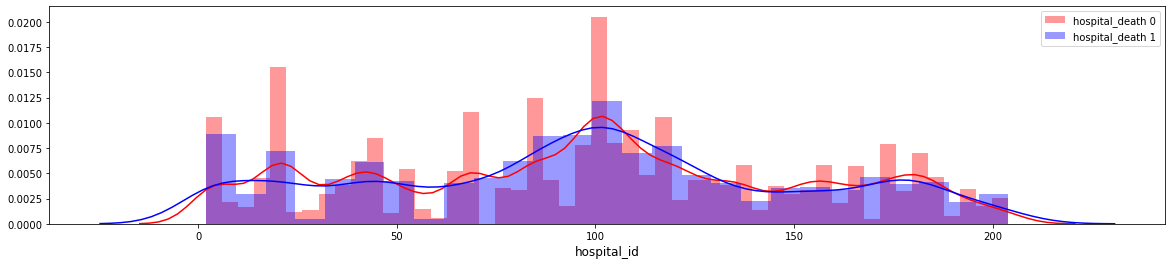

apache_4a_icu_death_prob 2 gain : 146275.1173324585


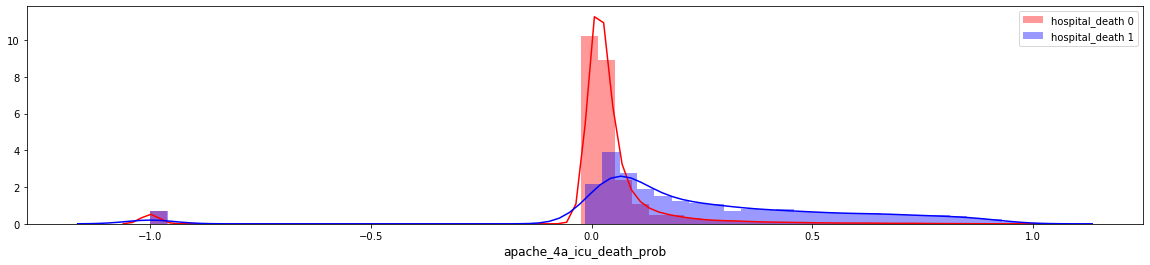

d1_lactate_min 3 gain : 55353.86215758324


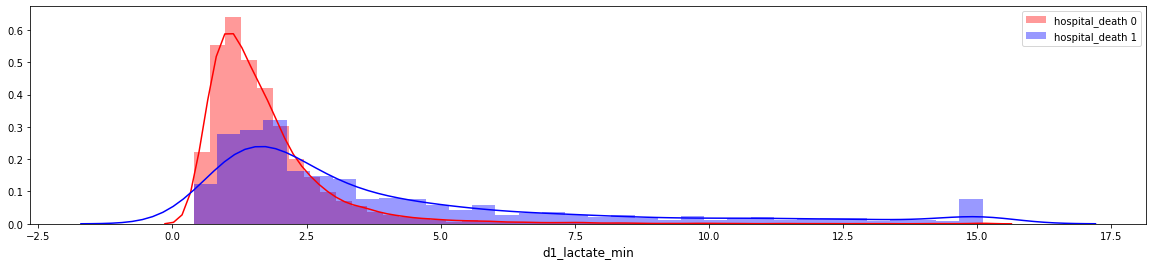

d1_spo2_min 4 gain : 31732.761485099792


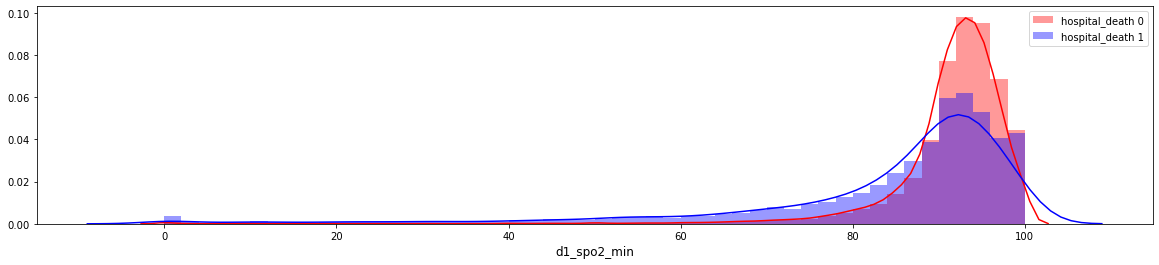

ventilated_apache 5 gain : 28691.33399581909


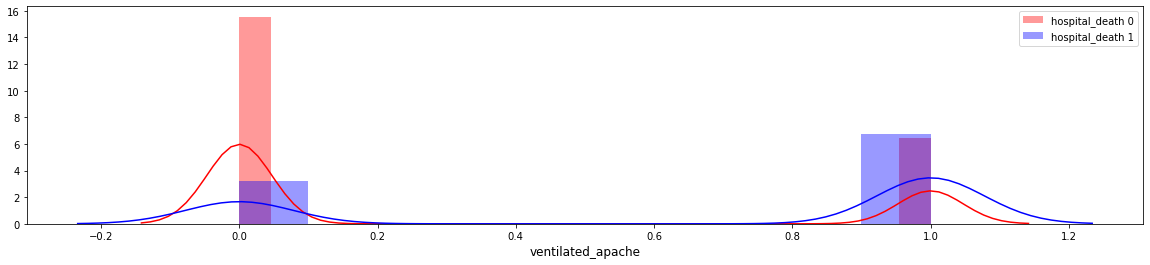

d1_sysbp_min 6 gain : 24419.43428516388


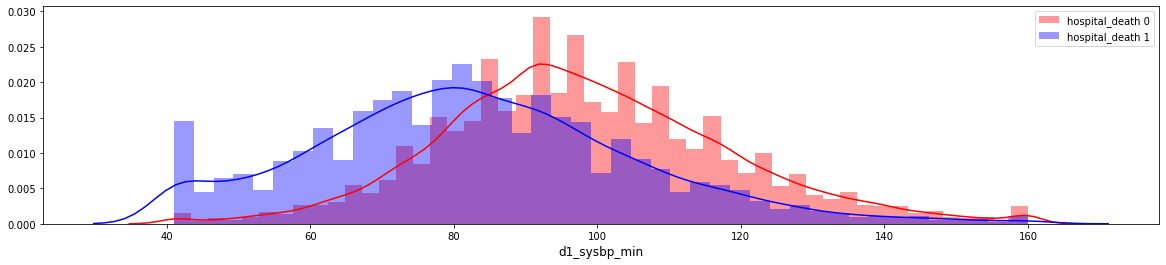

d1_heartrate_min 7 gain : 21757.668104171753


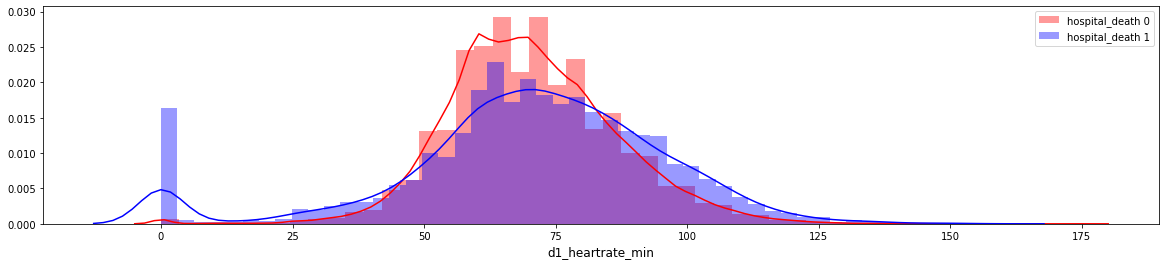

age 8 gain : 21481.372059106827


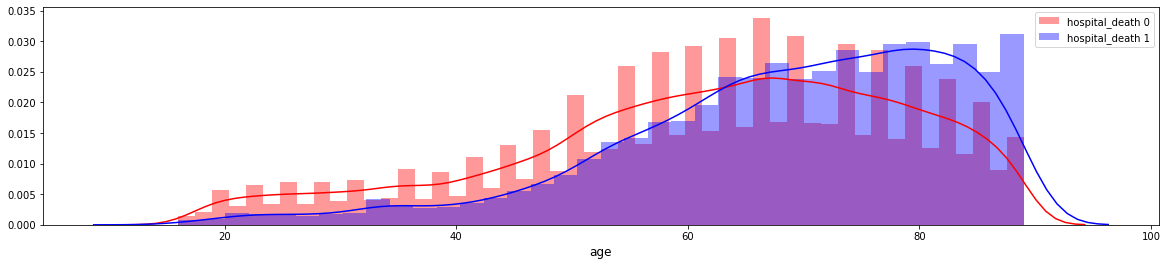

d1_bun_min 9 gain : 19529.879061460495


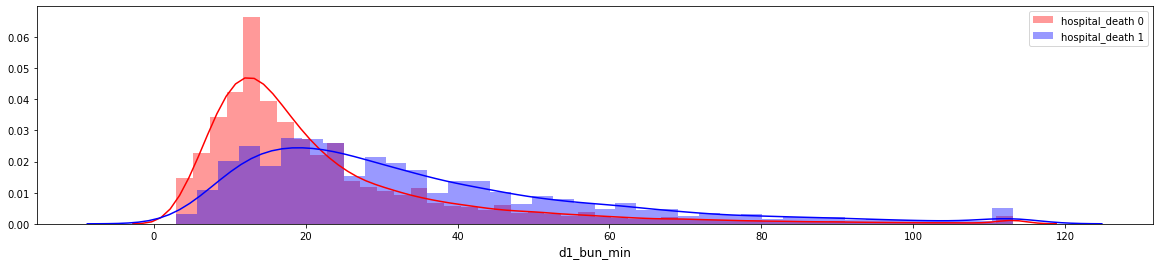

apache_3j_diagnosis 10 gain : 18576.375860452652


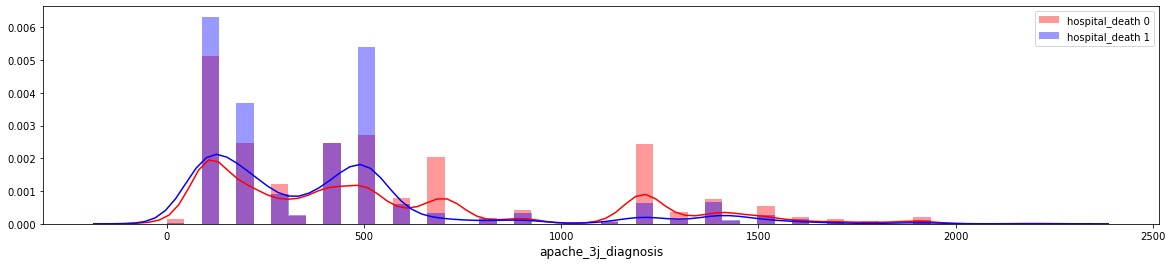

gcs_motor_apache 11 gain : 16573.00981283188


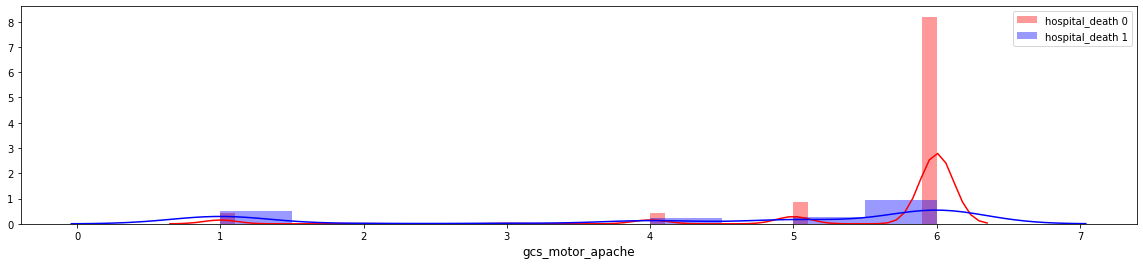

d1_temp_max 12 gain : 16168.361726999283


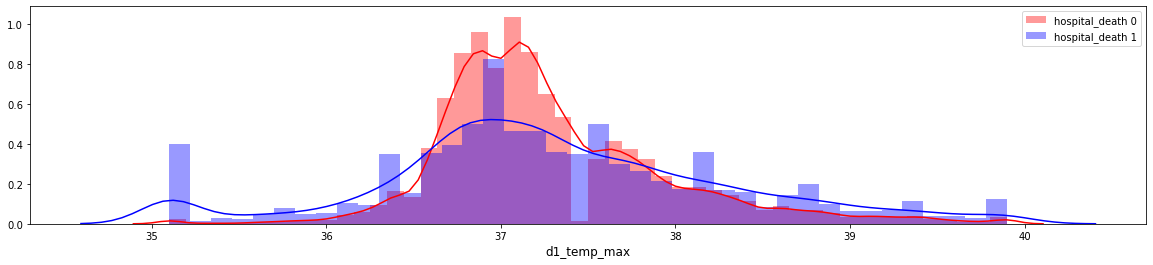

d1_sysbp_noninvasive_min 13 gain : 16028.458354949951


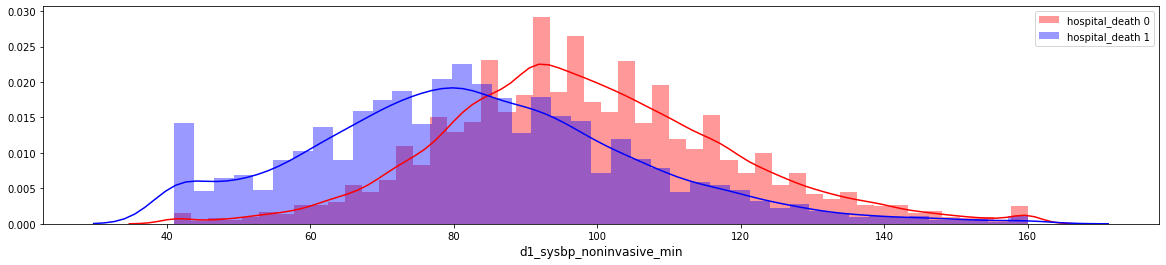

d1_lactate_max 14 gain : 14038.338047266006


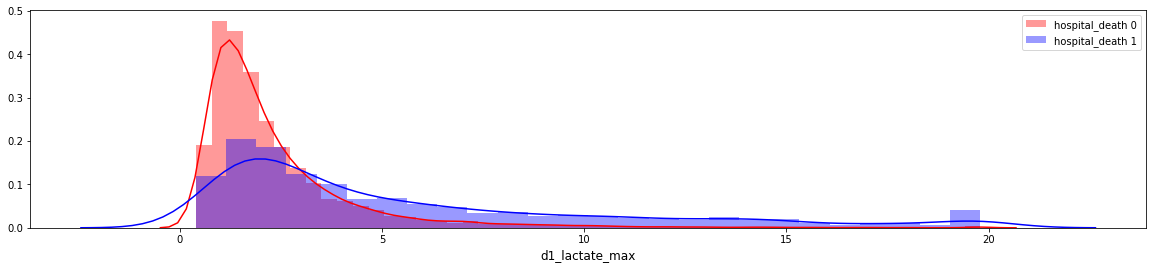

urineoutput_apache 15 gain : 13783.985323429108


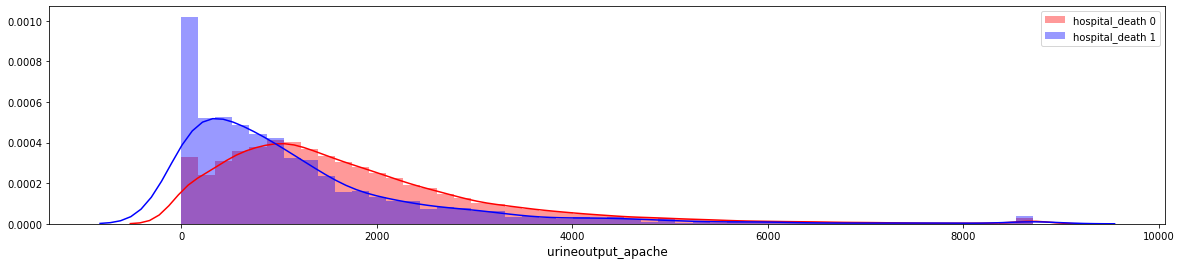

gcs_eyes_apache 16 gain : 13053.265293121338


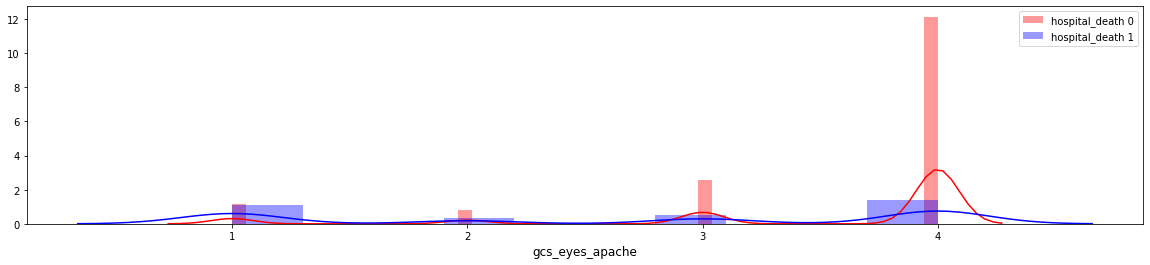

d1_platelets_min 17 gain : 12857.688428878784


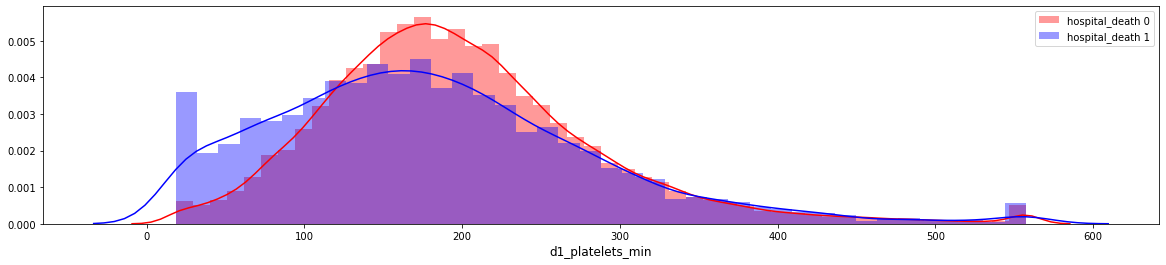

d1_arterial_ph_min 18 gain : 12081.881103992462


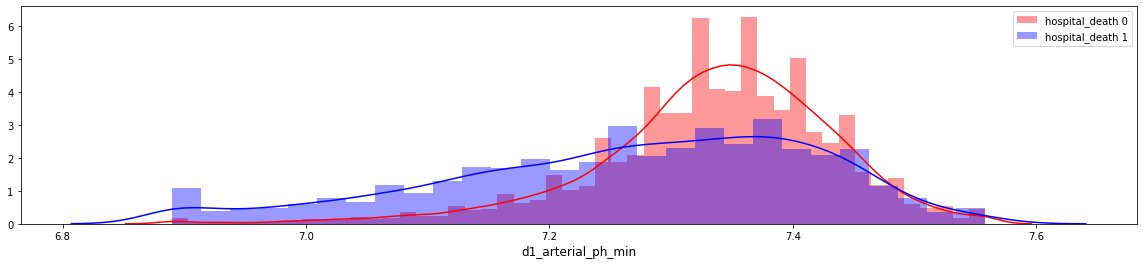

d1_resprate_min 19 gain : 11519.11014342308


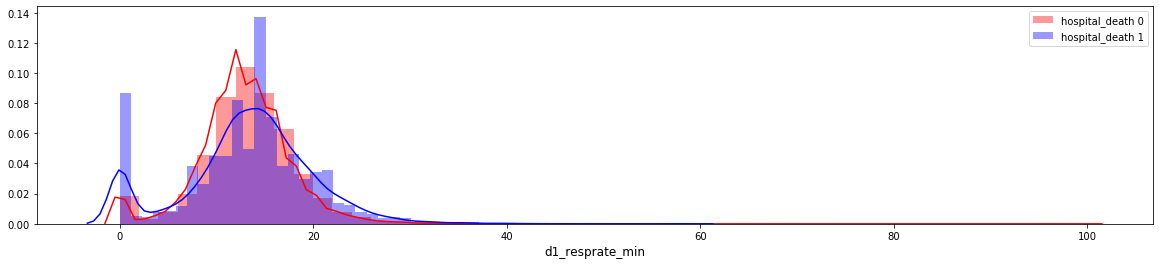

d1_bun_max 20 gain : 11254.286282539368


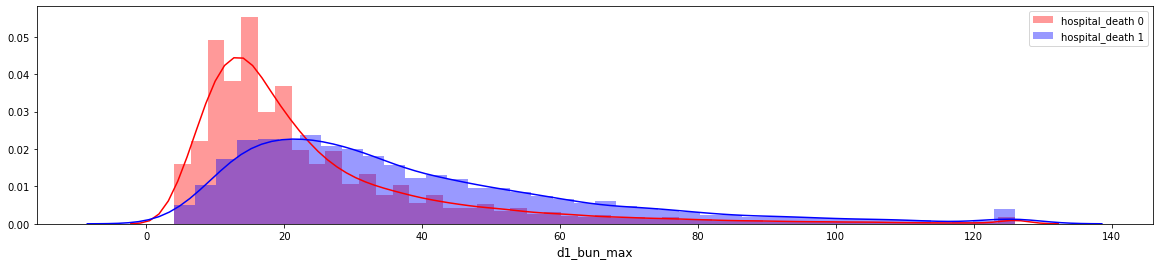

bmi 21 gain : 10985.150521993637


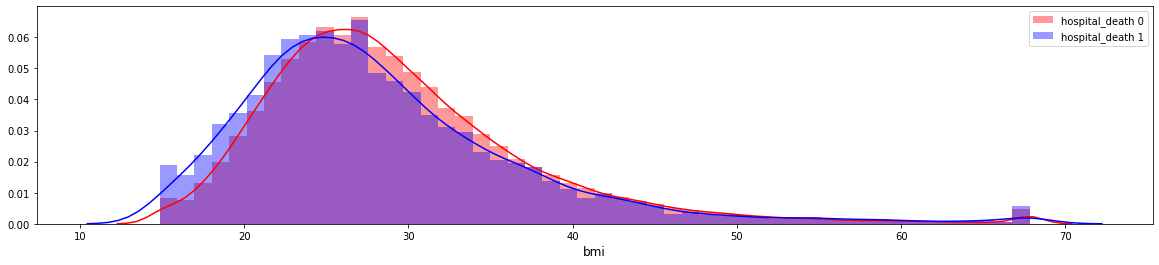

d1_temp_min 22 gain : 10853.892260551453


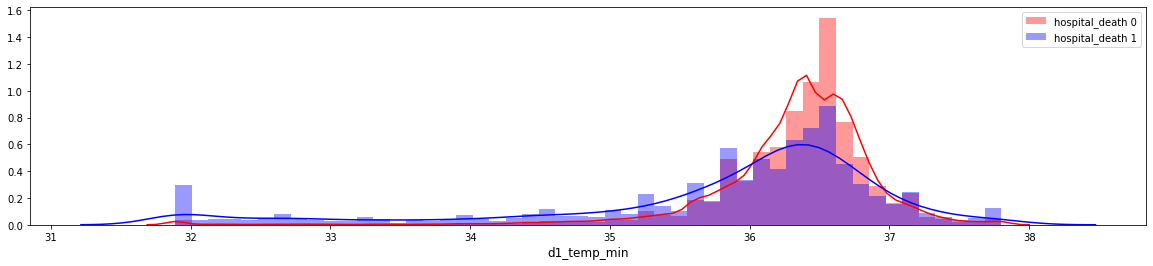

apache_3j_bodysystem 23 gain : 10575.751663684845


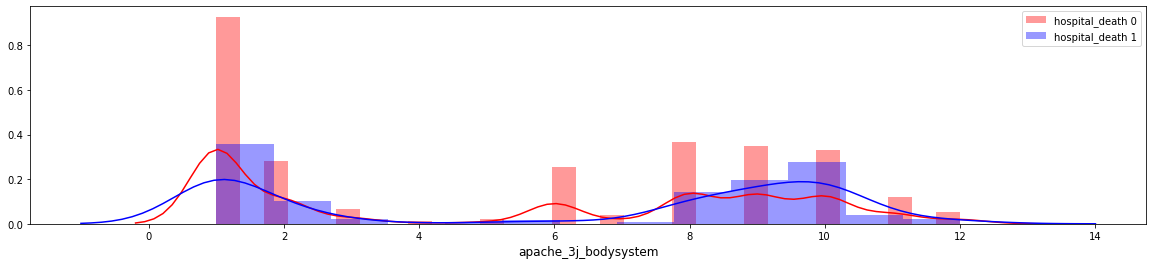

d1_resprate_max 24 gain : 10320.771817922592


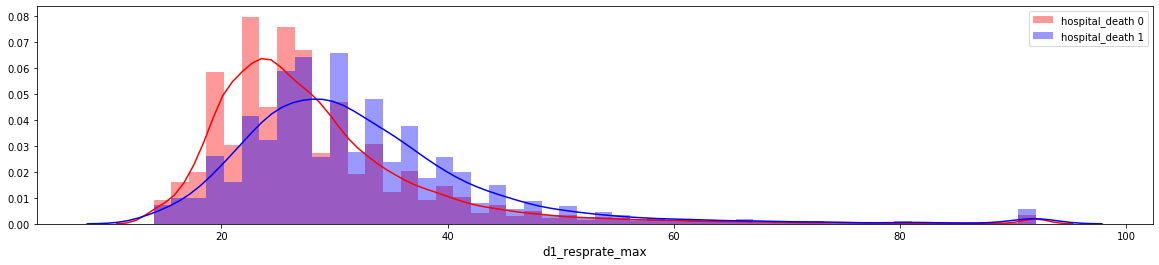

d1_heartrate_max 25 gain : 9808.910019397736


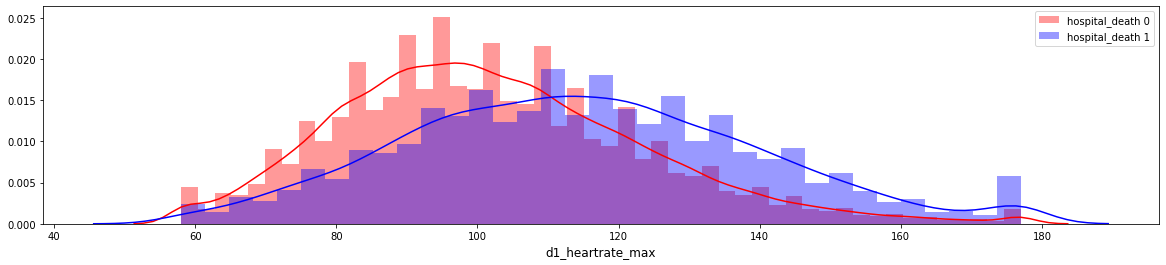

d1_glucose_min 26 gain : 9175.222955703735


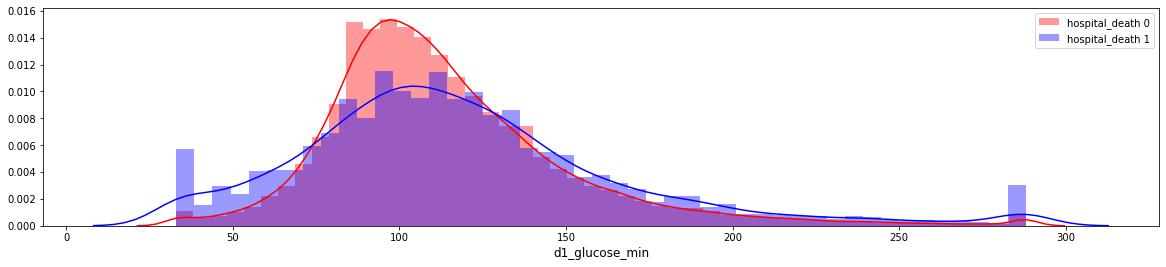

d1_wbc_min 27 gain : 9171.61188173294


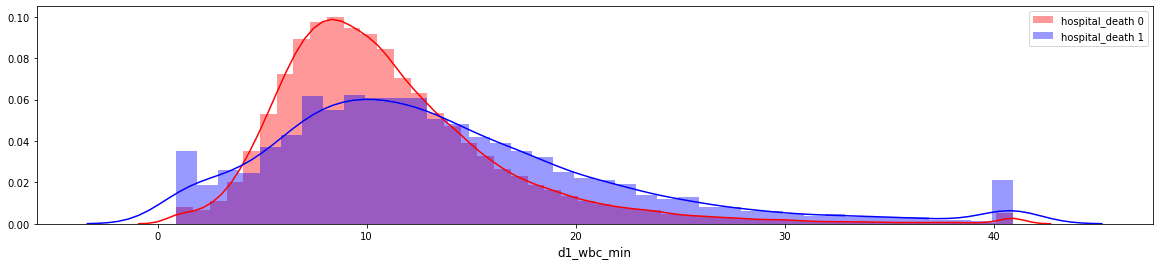

d1_pao2fio2ratio_max 28 gain : 8934.969403982162


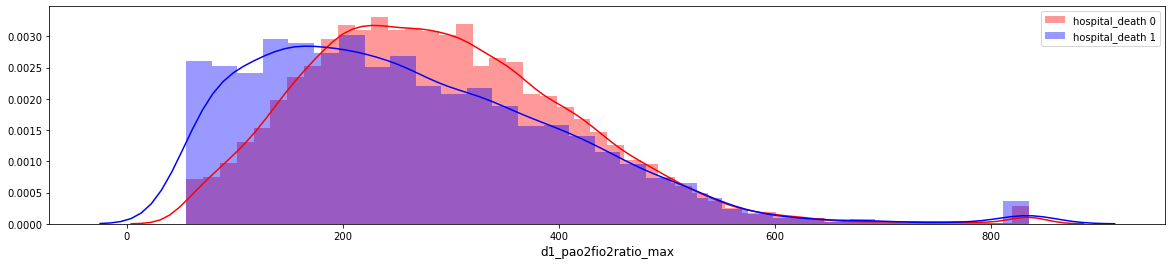

apache_2_diagnosis 29 gain : 8857.88154411316


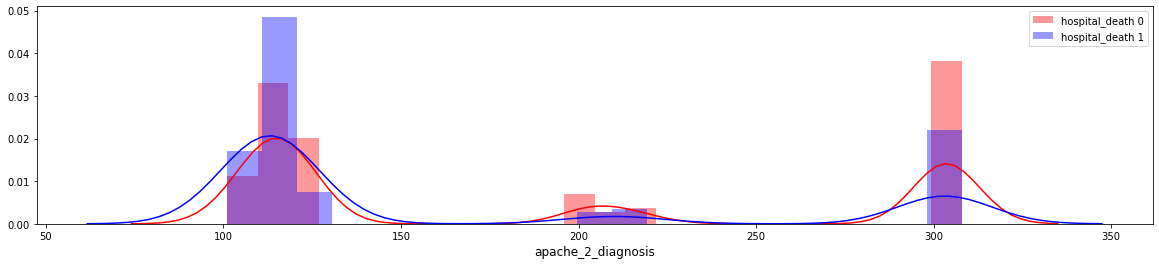

wbc_apache 30 gain : 8504.452875375748


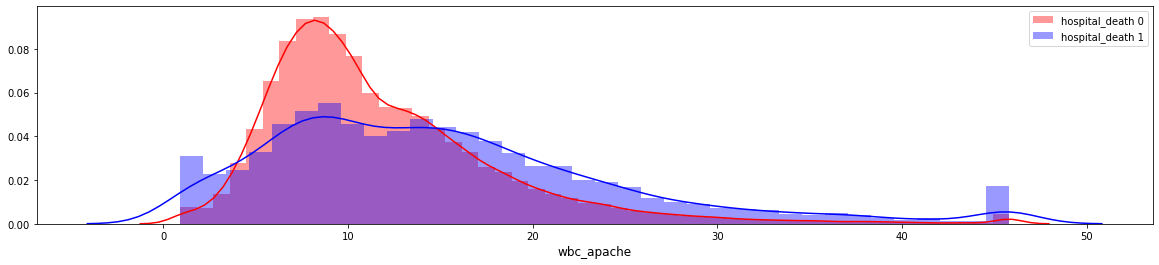

d1_sodium_max 31 gain : 8418.125189781189


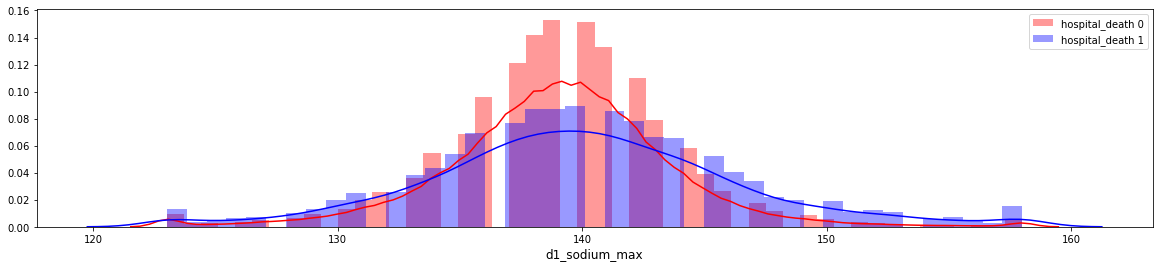

d1_arterial_ph_max 32 gain : 7989.068685293198


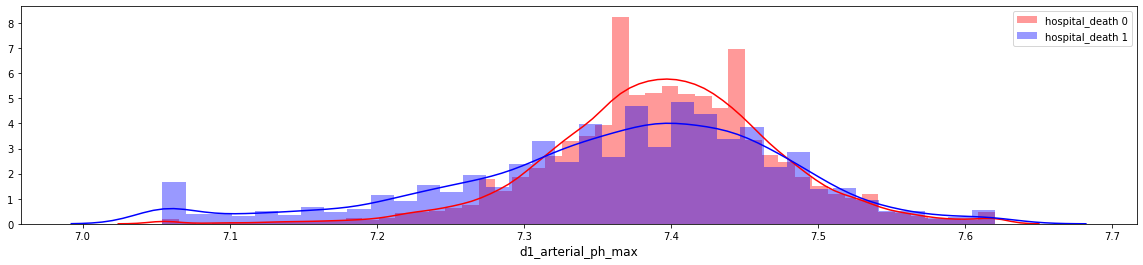

d1_hco3_min 33 gain : 7691.476171255112


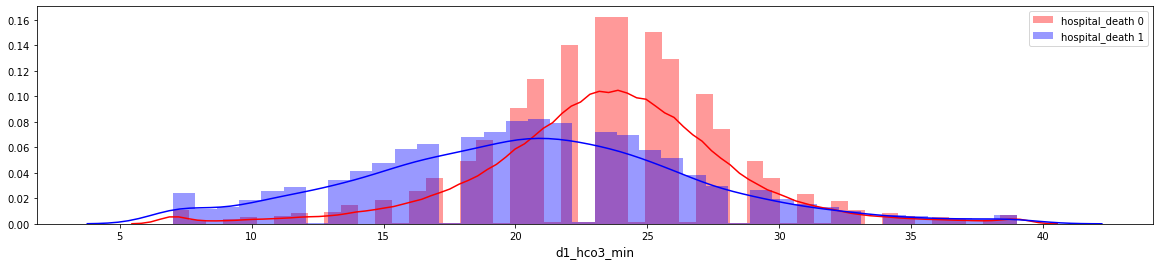

glucose_apache 34 gain : 7641.672451019287


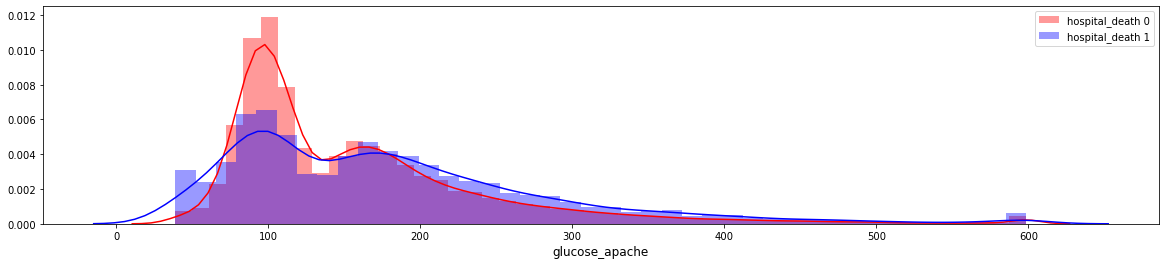

pre_icu_los_days 35 gain : 7494.74694108963


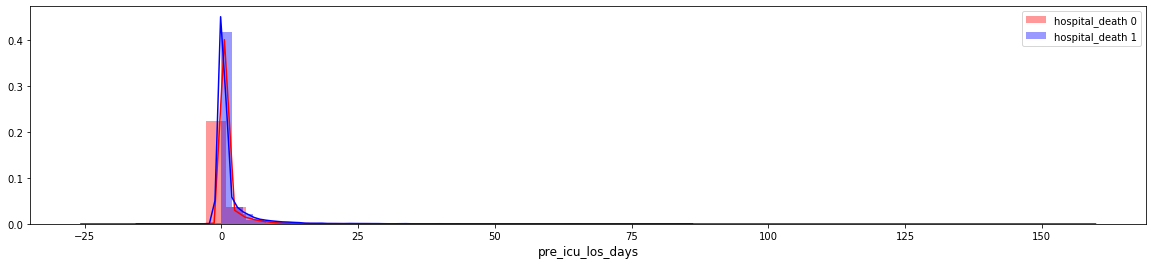

h1_resprate_min 36 gain : 7485.923817396164


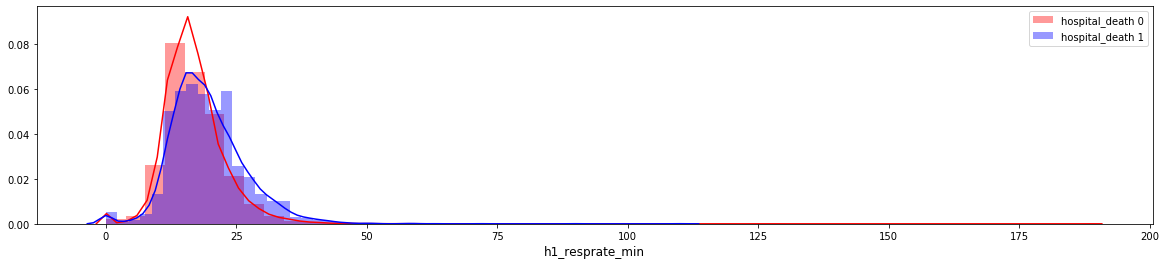

creatinine_apache 37 gain : 7413.3983066082


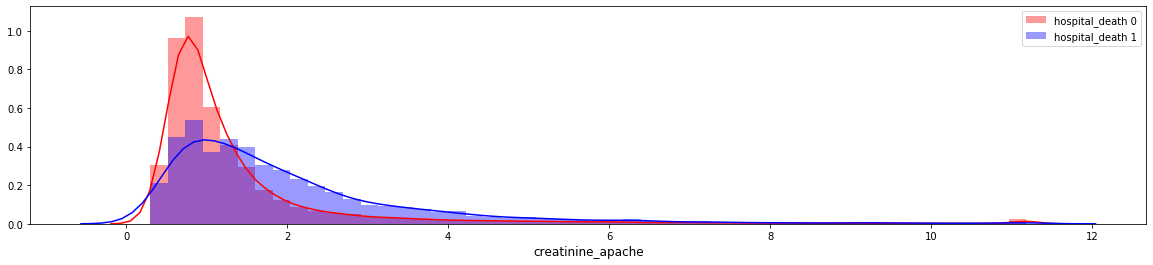

temp_apache 38 gain : 7281.159093618393


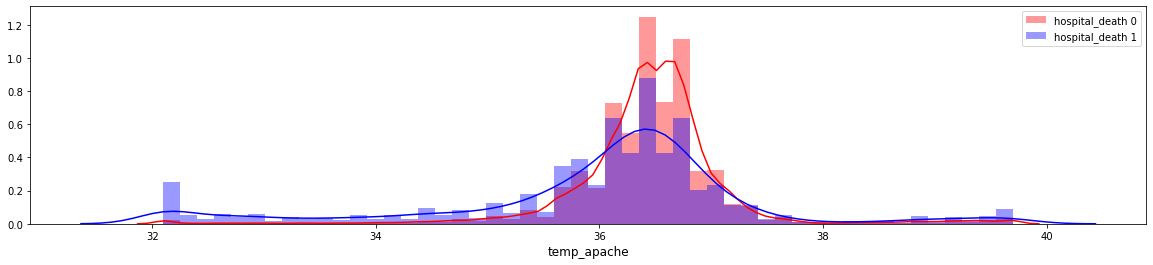

weight 39 gain : 6915.9319133758545


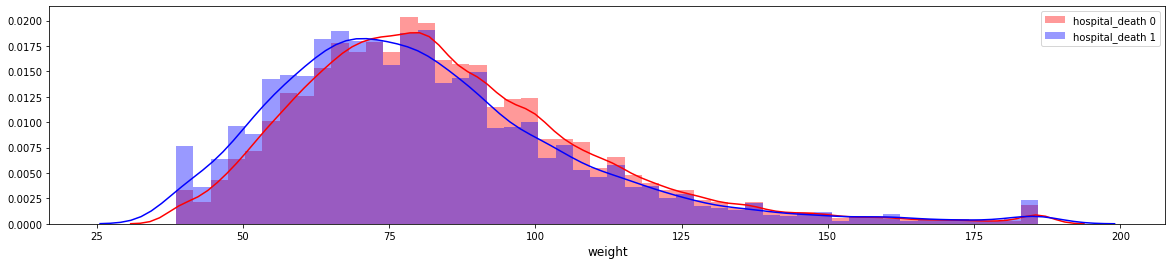

d1_platelets_max 40 gain : 6849.855688333511


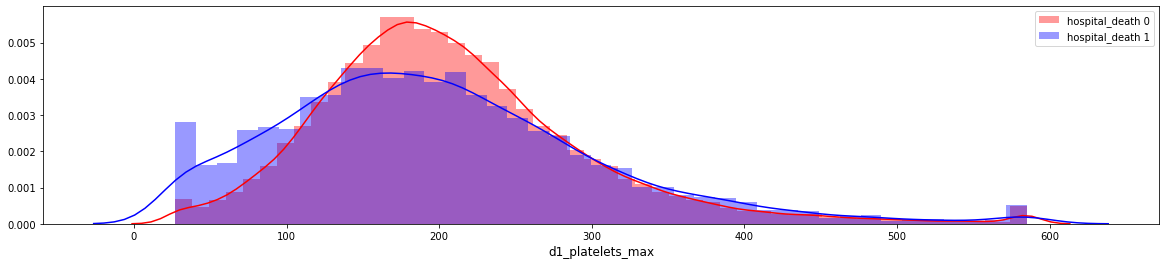

d1_pao2fio2ratio_min 41 gain : 6763.60645365715


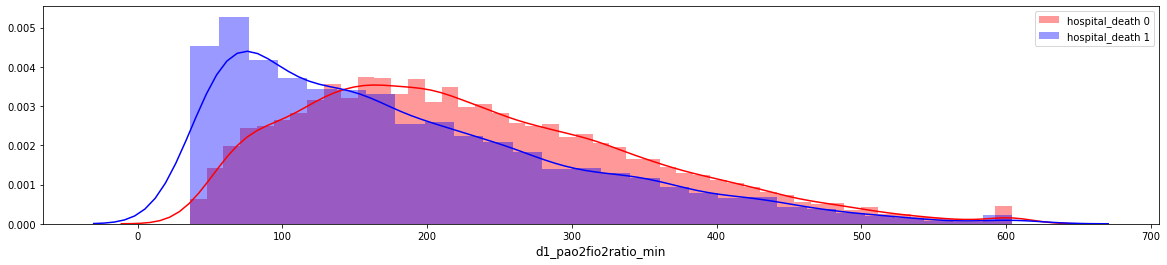

d1_sysbp_noninvasive_max 42 gain : 6714.262719631195


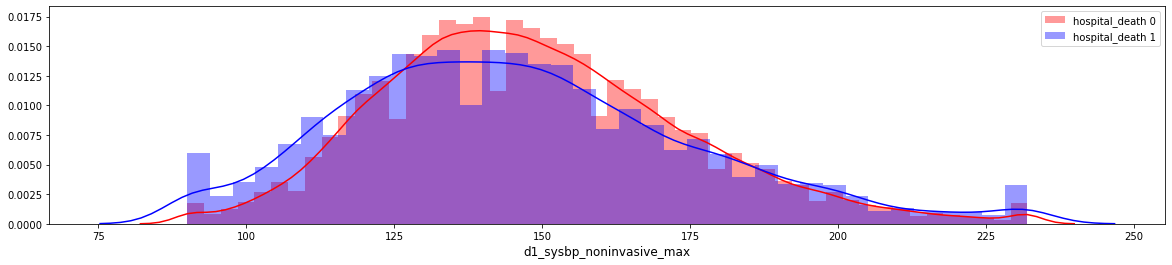

apache_2_bodysystem 43 gain : 6507.397555351257


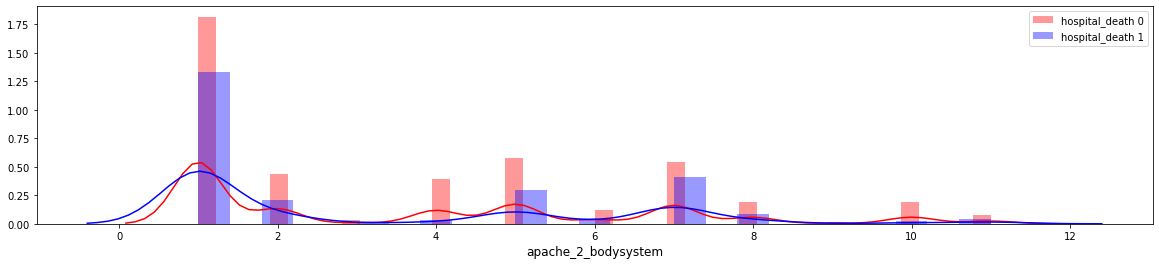

d1_mbp_min 44 gain : 6398.961150884628


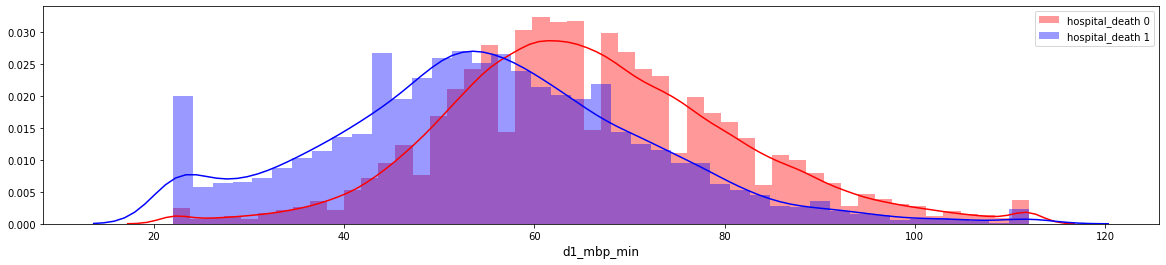

d1_hco3_max 45 gain : 6097.269358158112


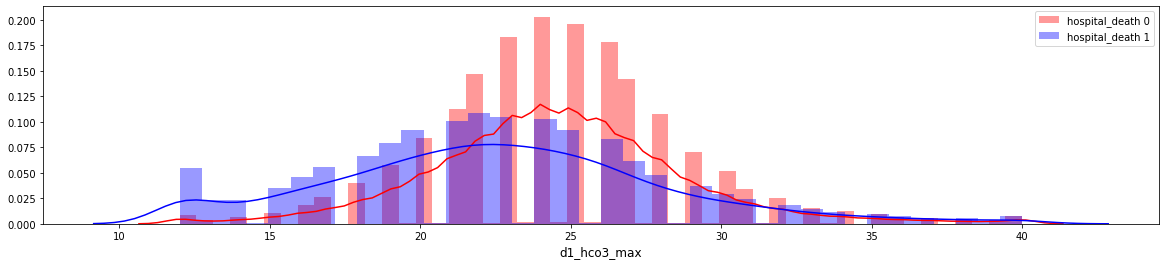

d1_inr_max 46 gain : 5984.607861280441


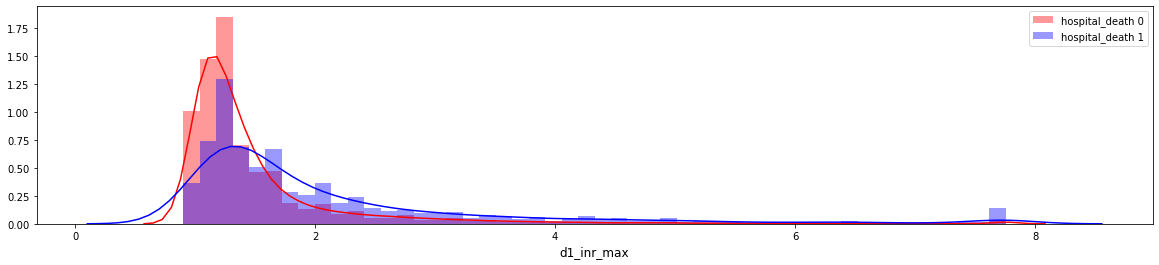

resprate_apache 47 gain : 5856.124365568161


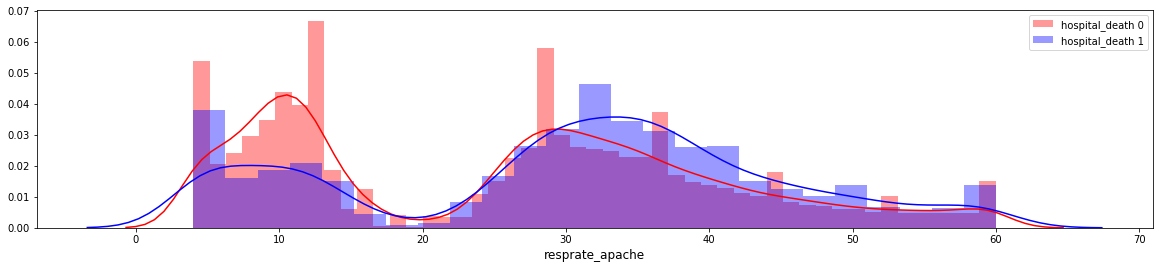

d1_hemaglobin_max 48 gain : 5758.485659599304


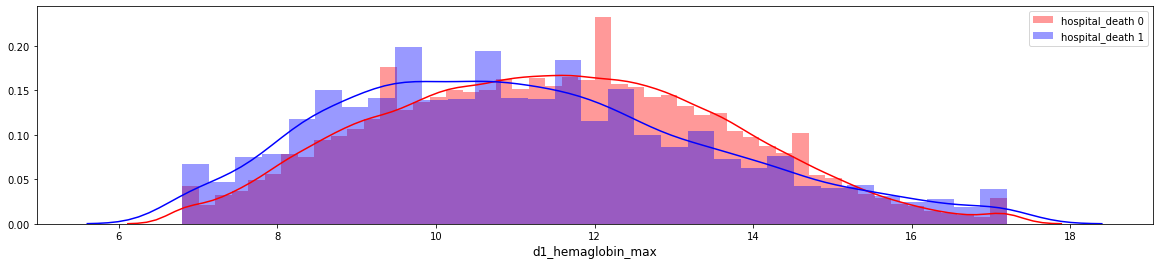

d1_mbp_noninvasive_min 49 gain : 5615.044913053513


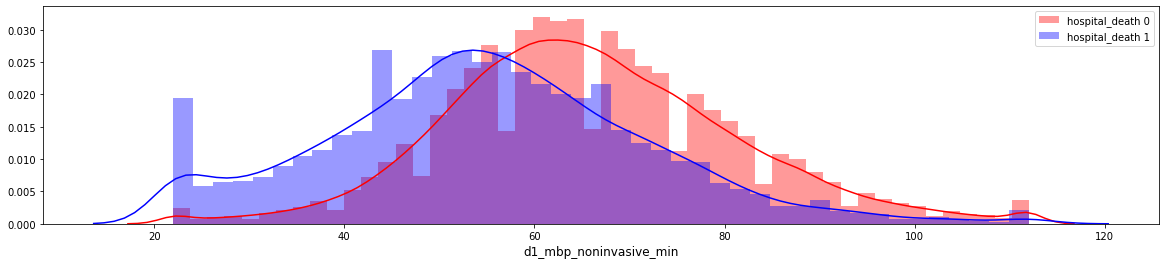

In [24]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


In [25]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission3-lgb-v2.csv",index=False)

test[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.01
1,5,0.02
2,7,0.01
3,8,0.12
4,10,0.67
